Starting Chef Recommendation System Evaluation

===== Loading Data =====
Data loaded in 0.01 seconds
Loaded 6 customers, 19 orders, 60 dishes, 12 chefs

===== Preprocessing Data =====
Available columns in orders DataFrame: ['order_id', 'customer_id', 'chef_id', 'dishes', 'numberOfPeople', 'diet', 'selectedDate', 'total', 'status', 'paymentMethod', 'paymentStatus', 'deliveryAddress']
Preprocessing completed in 0.10 seconds
Created user-item matrix with shape: (4, 11)

===== Training Models =====
Training SVD model...
RMSE: 0.0175
MAE:  0.0078
SVD Model - RMSE: 0.0175, MAE: 0.0078
SVD model trained in 0.00 seconds
Training Neural Collaborative Filtering model...


Epoch 1/3: 100%|██████████| 1/1 [00:00<00:00, 90.82it/s]


Epoch 1/3, Loss: 0.6517


Epoch 2/3: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s]


Epoch 2/3, Loss: 0.6934


Epoch 3/3: 100%|██████████| 1/1 [00:00<00:00, 80.89it/s]


Epoch 3/3, Loss: 0.6641
NCF model trained in 0.05 seconds
Training Wide & Deep model...


Epoch 1/3: 100%|██████████| 1/1 [00:00<00:00, 100.02it/s]


Epoch 1/3, Loss: 0.6996


Epoch 2/3: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s]


Epoch 2/3, Loss: 0.7534


Epoch 3/3: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s]


Epoch 3/3, Loss: 0.8077
Wide & Deep model trained in 0.05 seconds

===== Evaluating Models =====
Evaluating on 3 customers with sufficient order history


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 51.45it/s]



===== Model Performance Summary =====
           Model Precision  Recall F1 Score Avg Response Time (ms)
0  Content Based    0.1333  0.6667   0.2222                   1.67
1  Collaborative    0.0000  0.0000   0.0000                   4.39
2            Svd    0.0000  0.0000   0.0000                   1.00
3            Ncf    0.0000  0.0000   0.0000                   3.13
4      Wide Deep    0.0000  0.0000   0.0000                   1.90
5         Hybrid    0.0000  0.0000   0.0000                   7.01


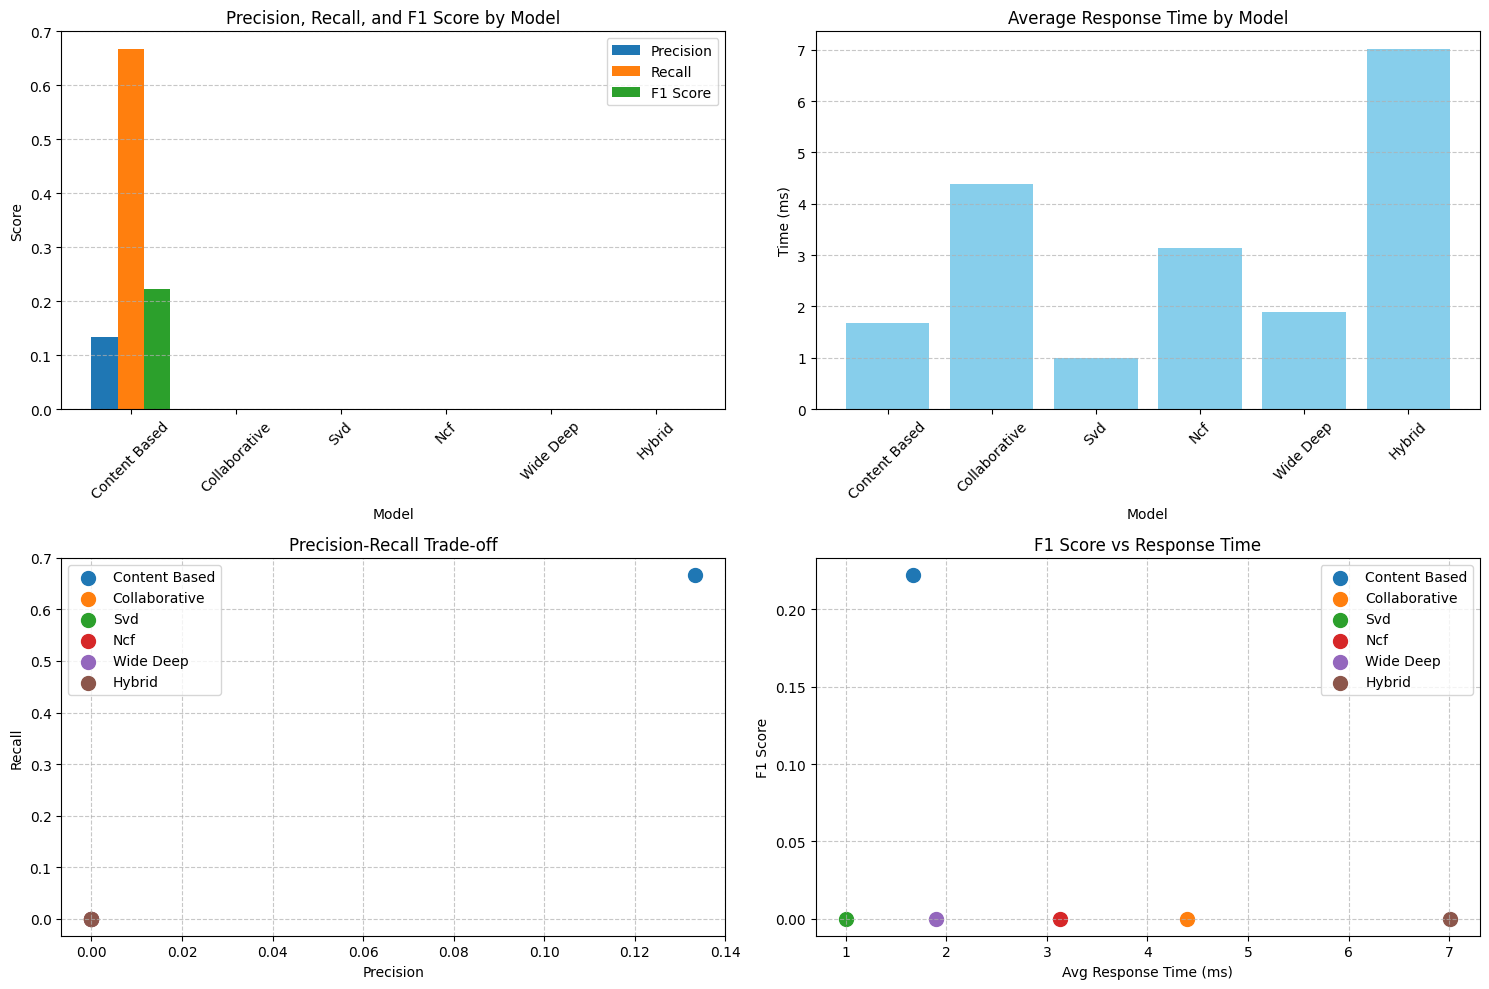


===== Sample Recommendations =====
Generating recommendations for customer: Tara Lopez (ID: CUST002)
                      Model        Chef Name   Score  Rating  \
0             Content Based       Jamie Lang  0.7200     3.6   
1             Content Based   Breanna Turner  0.6800     5.0   
2             Content Based  Alexander Lopez  0.5900     4.9   
3   Collaborative Filtering       Jamie Lang  0.6472     3.6   
4   Collaborative Filtering   Michael Carter  0.6000     4.1   
5   Collaborative Filtering    Thomas Snyder  0.6000     3.8   
6                       SVD  Hannah Williams  1.0000     3.9   
7                       SVD       Jamie Lang  1.0000     3.6   
8                       SVD     Tiffany Long  1.0000     3.3   
9                       NCF    Thomas Snyder  0.7124     3.8   
10                      NCF        Fred Lara  0.6462     4.2   
11                      NCF      Alison Boyd  0.5001     3.2   
12              Wide & Deep   Michael Carter  0.4653     4.1   
13

C:\Users\tejpa\AppData\Local\Temp\ipykernel_41496\2837850641.py:1233: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='Match Ratio', data=match_df, ci=None)


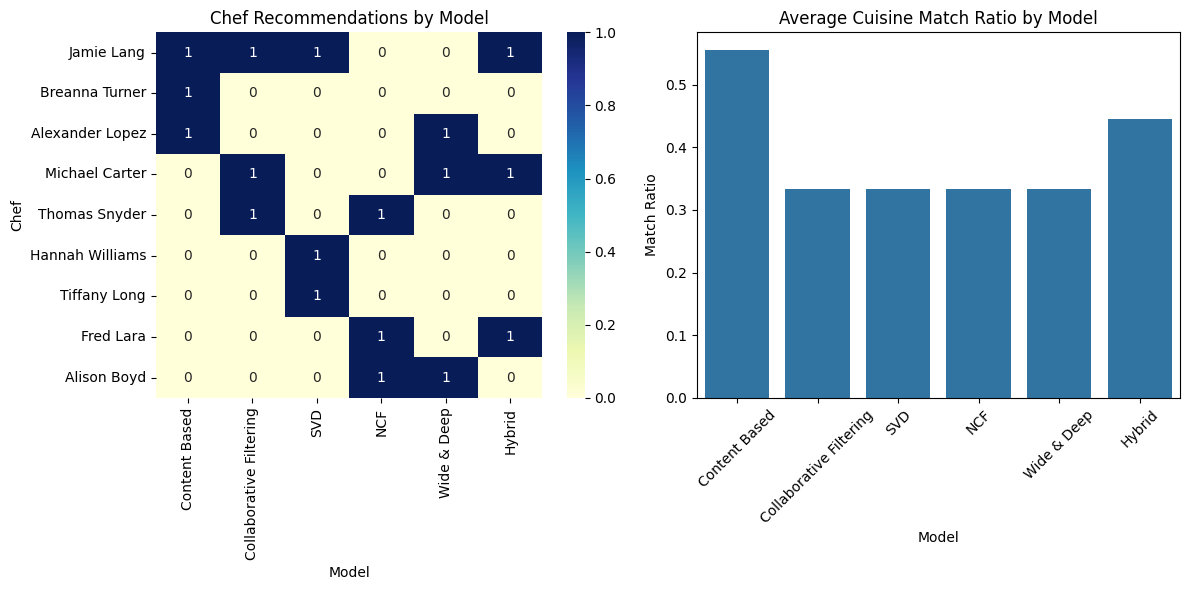


Evaluation complete! Visualizations have been saved to 'recommender_system_metrics.png' and 'recommendation_analysis.png'


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import networkx as nx
from surprise import Dataset as SurpriseDataset
from surprise import Reader, SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split as surprise_train_test_split
from collections import defaultdict
import re
import random
import time
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# --------------------- Data Loading and Preprocessing ---------------------
def load_data():
    """Load and preprocess all required datasets."""
    customers = pd.read_csv('customers.csv')
    orders = pd.read_csv('orders.csv')
    dishes = pd.read_csv('dishes.csv')
    chefs = pd.read_csv('chefs.csv')
    
    # Convert string representations of lists to actual lists
    customers['specialties preference'] = customers['specialties preference'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    chefs.specialties = chefs.specialties.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Parse dish information in orders
    orders.dishes = orders.dishes.apply(lambda x: json.loads(x.replace("'", "\"")) if isinstance(x, str) else x)
    
    return customers, orders, dishes, chefs

def preprocess_for_deep_learning(customers, orders, dishes, chefs):
    """
    Preprocess data for deep learning models.
    
    Returns:
    - interactions_df: DataFrame with user-item interactions
    - encoders: Dictionary of encoding mappings
    """
    # Check which column name is used for date in orders DataFrame
    date_column = None
    possible_date_columns = ['timestamp', 'datetime', 'created_at', 'created_date', 'selectedDate']
    for col in possible_date_columns:
        if col in orders.columns:
            date_column = col
            break
    
    if date_column is None:
        print("Warning: No date column found in orders DataFrame. Using current time as fallback.")
    
    # Create a list of columns in the orders DataFrame for debugging
    print(f"Available columns in orders DataFrame: {orders.columns.tolist()}")
    
    # Add a timestamp column with current time as fallback if needed
    if date_column is None:
        orders['timestamp'] = int(time.time())
        date_column = 'timestamp'
    
    # Create customer and chef ID mappings
    customer_to_idx = {cid: i for i, cid in enumerate(customers.customer_id.unique())}
    chef_to_idx = {cid: i for i, cid in enumerate(chefs.chef_id.unique())}
    idx_to_customer = {i: cid for cid, i in customer_to_idx.items()}
    idx_to_chef = {i: cid for cid, i in chef_to_idx.items()}
    
    n_customers = len(customer_to_idx)
    n_chefs = len(chef_to_idx)
    
    # Create interaction data
    interactions = []
    for _, order in orders.iterrows():
        customer_id = order.customer_id
        chef_id = order.chef_id
        
        # Use the identified date column or fallback
        if date_column == 'timestamp':
            timestamp = order[date_column]  # Already an integer timestamp
        else:
            try:
                timestamp = pd.to_datetime(order[date_column]).timestamp()
            except:
                # If conversion fails, use the index as a proxy for time ordering
                timestamp = orders.index.get_loc(order.name)
        
        # Add customer-chef interaction
        interactions.append({
            'customer_id': customer_id,
            'chef_id': chef_id,
            'timestamp': timestamp,
            'rating': 1,  # Implicit rating (ordered = positive interaction)
        })
    
    # Create DataFrame from interactions
    interactions_df = pd.DataFrame(interactions)
    
    # Encode IDs for deep learning models
    interactions_df['customer_idx'] = interactions_df['customer_id'].map(customer_to_idx)
    interactions_df['chef_idx'] = interactions_df['chef_id'].map(chef_to_idx)
    
    # Return preprocessed data and encoders
    encoders = {
        'customer_to_idx': customer_to_idx,
        'chef_to_idx': chef_to_idx,
        'idx_to_customer': idx_to_customer,
        'idx_to_chef': idx_to_chef,
        'n_customers': n_customers,
        'n_chefs': n_chefs
    }
    
    return interactions_df, encoders

def create_surprise_dataset(orders):
    """Create a dataset for SVD using Surprise library."""
    # Extract customer-chef interactions
    interactions = []
    for _, order in orders.iterrows():
        customer_id = order.customer_id
        chef_id = order.chef_id
        # Using implicit feedback (1 for interaction)
        interactions.append([customer_id, chef_id, 1])
    
    # Convert to DataFrame
    df = pd.DataFrame(interactions, columns=['customer_id', 'chef_id', 'rating'])
    
    # Create Surprise dataset
    reader = Reader(rating_scale=(0, 1))
    return SurpriseDataset.load_from_df(df[['customer_id', 'chef_id', 'rating']], reader)

def create_chef_embeddings(chefs, dishes):
    """Create text-based embeddings for chefs based on their specialties and dish descriptions."""
    # Combine chef specialties
    chef_text = {}
    for _, chef in chefs.iterrows():
        chef_id = chef.chef_id
        specialties = ' '.join(chef.specialties)
        chef_text[chef_id] = specialties
    
    # Add dish descriptions for each chef
    for _, dish in dishes.iterrows():
        chef_id = dish.chef_id
        if chef_id in chef_text:
            #description = dish.description if isinstance(dish.description, str) else ''
            category = dish.category if isinstance(dish.category, str) else ''
            subcategory = dish.subCategory if isinstance(dish.subCategory, str) else ''
            chef_text[chef_id] += f" {category} {subcategory}"
    
    # Create TF-IDF vectors
    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    
    # Convert dictionary to DataFrame for vectorization
    chef_text_df = pd.DataFrame(list(chef_text.items()), columns=['chef_id', 'text'])
    chef_vectors = tfidf.fit_transform(chef_text_df.text.fillna(''))
    
    # Create embedding dictionary
    chef_embeddings = {}
    for i, chef_id in enumerate(chef_text_df.chef_id):
        chef_embeddings[chef_id] = chef_vectors[i].toarray().flatten()
    
    return chef_embeddings, tfidf

def create_customer_embeddings(customers, orders, dishes, chef_embeddings):
    """Create embeddings for customers based on their preferences and order history."""
    customer_embeddings = {}
    for _, customer in customers.iterrows():
        customer_id = customer.customer_id
        
        # Start with preference-based features
        cuisine_prefs = customer['specialties preference']
        diet_pref = customer.preference
        
        # Use orders to build profile if available
        customer_orders = orders[orders.customer_id == customer_id]
        if len(customer_orders) > 0:
            # Average chef embeddings from orders
            chef_embedding_sum = np.zeros(next(iter(chef_embeddings.values())).shape)
            chef_count = 0
            
            for _, order in customer_orders.iterrows():
                chef_id = order.chef_id
                if chef_id in chef_embeddings:
                    chef_embedding_sum += chef_embeddings[chef_id]
                    chef_count += 1
            
            if chef_count > 0:
                customer_embeddings[customer_id] = chef_embedding_sum / chef_count
            else:
                # Fallback to zero vector if no chef embeddings available
                customer_embeddings[customer_id] = np.zeros(next(iter(chef_embeddings.values())).shape)
        else:
            # For new users, create a zero vector
            customer_embeddings[customer_id] = np.zeros(next(iter(chef_embeddings.values())).shape)
    
    return customer_embeddings

def create_graph_embeddings(orders, customers, chefs, dishes):
    """Create graph embeddings using NetworkX for a knowledge graph approach."""
    # Create a heterogeneous graph
    G = nx.Graph()
    
    # Add nodes
    for _, customer in customers.iterrows():
        G.add_node(customer.customer_id, type='customer', diet=customer.preference, cuisines=','.join(customer['specialties preference']))
    
    for _, chef in chefs.iterrows():
        G.add_node(chef.chef_id, type='chef', cuisines=','.join(chef.specialties), rating=chef.averageRating, experience=chef.experience)
    
    for _, dish in dishes.iterrows():
        G.add_node(dish.dish_id, type='dish', category=dish.category, subcategory=dish.subCategory)
    
    # Add edges
    for _, order in orders.iterrows():
        customer_id = order.customer_id
        chef_id = order.chef_id
        
        # Customer ordered from chef
        G.add_edge(customer_id, chef_id, type='ordered_from')
        
        # Customer ordered dishes
        for dish_item in order.dishes:
            if isinstance(dish_item, dict) and 'dish' in dish_item:
                dish_id = dish_item['dish']
                G.add_edge(customer_id, dish_id, type='ordered')
                G.add_edge(chef_id, dish_id, type='created')
    
    # Add edges between chefs with similar specialties
    for i, chef1 in chefs.iterrows():
        for j, chef2 in chefs.iterrows():
            if i < j:  # Avoid duplicates
                specialties1 = set(chef1.specialties)
                specialties2 = set(chef2.specialties)
                common = len(specialties1.intersection(specialties2))
                if common > 0:
                    similarity = common / len(specialties1.union(specialties2))
                    if similarity > 0.3:  # Only connect if similarity is significant
                        G.add_edge(chef1.chef_id, chef2.chef_id, type='similar_specialties', weight=similarity)
    
    # Use personalized PageRank for embedding
    embeddings = {}
    
    # For each node, compute personalized PageRank and use as embedding
    for node in G.nodes():
        if G.degree(node) > 0:  # Skip isolated nodes
            personalization = {n: 0.0 for n in G.nodes()}
            personalization[node] = 1.0
            pr = nx.pagerank(G, alpha=0.85, personalization=personalization)
            
            # Convert to vector (sorted by node ID for consistency)
            embedding = np.array([pr[n] for n in sorted(G.nodes())])
            embeddings[node] = embedding
        else:
            # Fallback for isolated nodes
            embeddings[node] = np.zeros(len(G.nodes()))
    
    return embeddings, G

# --------------------- Existing Recommendation Models ---------------------
def content_based_recommendations(customer_id, customers, chefs, top_n=3):
    """
    Recommend chefs based on matching customer preferences with chef specialties.
    Used for new customers without order history.
    """
    customer = customers[customers.customer_id == customer_id].iloc[0]
    
    # Get customer's diet preference and cuisine specialties
    diet_pref = customer['preference']
    cuisine_prefs = customer['specialties preference']
    
    # Create a feature vector for each chef
    chef_features = []
    for _, chef in chefs.iterrows():
        # Calculate cuisine match score (how many customer preferences match chef specialties)
        cuisine_match = sum(cuisine in chef['specialties'] for cuisine in cuisine_prefs) if len(cuisine_prefs) > 0 else 0
        cuisine_match_ratio = cuisine_match / len(cuisine_prefs) if len(cuisine_prefs) > 0 else 0
        
        # Consider chef rating and experience
        chef_score = (chef['averageRating'] / 5) * 0.5 + (chef['experience'] / 10) * 0.2 + cuisine_match_ratio * 0.3
        
        chef_features.append({
            'chef_id': chef['chef_id'],
            'name': chef['name'],
            'score': chef_score,
            'cuisine_match': cuisine_match_ratio,
            'rating': chef['averageRating'],
            'specialties': chef['specialties']
        })
    
    # Sort chefs by score
    chef_features.sort(key=lambda x: x['score'], reverse=True)
    
    return chef_features[:top_n]

def create_user_item_matrix(orders, customers, chefs):
    """
    Create a matrix where rows are customers and columns are chefs.
    Each cell contains the number of times a customer ordered from a chef.
    """
    # Count orders for each customer-chef pair
    customer_chef_counts = orders.groupby(['customer_id', 'chef_id']).size().reset_index(name='order_count')
    
    # Create pivot table
    user_item_matrix = customer_chef_counts.pivot(
        index='customer_id', 
        columns='chef_id', 
        values='order_count'
    ).fillna(0)
    
    return user_item_matrix

def collaborative_filtering(customer_id, user_item_matrix, customers, chefs, top_n=3):
    """
    Recommend chefs based on customer's previous orders and similarity to other customers.
    Used for existing customers with order history.
    """
    # Check if customer exists in matrix
    if customer_id not in user_item_matrix.index:
        return []
    
    # Calculate cosine similarity between users
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(
        user_similarity,
        index=user_item_matrix.index,
        columns=user_item_matrix.index
    )
    
    # Get similar users to our target customer
    similar_users = user_similarity_df[customer_id].sort_values(ascending=False)[1:6]  # Top 5 similar users
    
    # Which chefs has the customer already ordered from?
    customer_chefs = user_item_matrix.loc[customer_id]
    customer_chefs = set(customer_chefs[customer_chefs > 0].index)
    
    # Collect recommendations from similar users
    chef_scores = {}
    for similar_user, similarity in similar_users.items():
        if similarity <= 0:  # Skip negatively correlated users
            continue
            
        # Get chefs this similar user has ordered from
        user_chefs = user_item_matrix.loc[similar_user]
        user_chefs = set(user_chefs[user_chefs > 0].index)
        
        # Recommend chefs this similar user has ordered from but our target customer hasn't
        for chef_id in user_chefs - customer_chefs:
            if chef_id not in chef_scores:
                chef_scores[chef_id] = 0
            chef_scores[chef_id] += similarity * user_item_matrix.loc[similar_user, chef_id]
    
    # Sort chefs by score and get top_n
    recommended_chefs = sorted(chef_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Get chef details
    chef_details = []
    for chef_id, score in recommended_chefs:
        chef = chefs[chefs['chef_id'] == chef_id].iloc[0]
        chef_details.append({
            'chef_id': chef_id,
            'name': chef['name'],
            'score': score,
            'rating': chef['averageRating'],
            'specialties': chef['specialties']
        })
    
    return chef_details

# --------------------- Matrix Factorization with Surprise ---------------------

def train_svd_model(surprise_data):
    """Train an SVD model using the Surprise library."""
    # Split data into train and test sets
    trainset, testset = surprise_train_test_split(surprise_data, test_size=0.25)
    
    # Train SVD model
    algo = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)
    algo.fit(trainset)
    
    # Evaluate on test set
    test_predictions = algo.test(testset)
    rmse = accuracy.rmse(test_predictions)
    mae = accuracy.mae(test_predictions)
    
    print(f"SVD Model - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
    return algo

def svd_recommendations(customer_id, svd_model, chefs, top_n=3, excluded_chef_ids=None):
    """Generate recommendations using trained SVD model."""
    if excluded_chef_ids is None:
        excluded_chef_ids = set()
    
    # Get predictions for all chefs the customer hasn't interacted with
    chef_predictions = []
    
    for _, chef in chefs.iterrows():
        chef_id = chef['chef_id']
        
        if chef_id in excluded_chef_ids:
            continue
        
        # Get prediction
        prediction = svd_model.predict(customer_id, chef_id)
        
        chef_predictions.append({
            'chef_id': chef_id,
            'name': chef['name'],
            'score': prediction.est,
            'rating': chef['averageRating'],
            'specialties': chef['specialties']
        })
    
    # Sort by predicted rating
    chef_predictions.sort(key=lambda x: x['score'], reverse=True)
    
    return chef_predictions[:top_n]

# --------------------- Deep Learning Models ---------------------

class NCFDataset(Dataset):
    """Dataset for Neural Collaborative Filtering."""
    def __init__(self, interactions_df, n_chefs, negative_samples=4):
        self.interactions_df = interactions_df
        self.n_chefs = n_chefs
        self.negative_samples = negative_samples
        
        # Create set of existing interactions for negative sampling
        self.user_item_set = set(zip(
            interactions_df['customer_idx'].tolist(),
            interactions_df['chef_idx'].tolist()
        ))
        
        # List of all chef indices
        self.all_chefs = list(range(n_chefs))
    
    def __len__(self):
        return len(self.interactions_df) * (1 + self.negative_samples)
    
    def __getitem__(self, idx):
        # Determine if this is a positive or negative sample
        pos_idx = idx // (1 + self.negative_samples)
        is_positive = (idx % (1 + self.negative_samples) == 0)
        
        # Get positive sample
        customer_idx = self.interactions_df.iloc[pos_idx]['customer_idx']
        
        if is_positive:
            chef_idx = self.interactions_df.iloc[pos_idx]['chef_idx']
            rating = 1.0
        else:
            # Generate negative sample
            while True:
                chef_idx = random.choice(self.all_chefs)
                if (customer_idx, chef_idx) not in self.user_item_set:
                    break
            rating = 0.0
        
        return {
            'customer_idx': torch.tensor(customer_idx, dtype=torch.long),
            'chef_idx': torch.tensor(chef_idx, dtype=torch.long),
            'rating': torch.tensor(rating, dtype=torch.float)
        }

class NeuralCollaborativeFiltering(nn.Module):
    """Neural Collaborative Filtering model."""
    def __init__(self, n_customers, n_chefs, embedding_dim=32, hidden_layers=[64, 32, 16]):
        super(NeuralCollaborativeFiltering, self).__init__()
        
        # Embedding layers
        self.customer_embedding = nn.Embedding(n_customers, embedding_dim)
        self.chef_embedding = nn.Embedding(n_chefs, embedding_dim)
        
        # MLP layers
        self.fc_layers = nn.ModuleList()
        input_size = 2 * embedding_dim
        
        for i, layer_size in enumerate(hidden_layers):
            self.fc_layers.append(nn.Linear(input_size, layer_size))
            input_size = layer_size
        
        # Final prediction layer
        self.output_layer = nn.Linear(hidden_layers[-1], 1)
        
        # Matrix factorization path for integration
        self.mf_output = nn.Linear(embedding_dim, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, customer_idx, chef_idx):
        # Get embeddings
        customer_emb = self.customer_embedding(customer_idx)
        chef_emb = self.chef_embedding(chef_idx)
        
        # MLP path
        mlp_input = torch.cat([customer_emb, chef_emb], dim=1)
        
        for layer in self.fc_layers:
            mlp_input = self.relu(layer(mlp_input))
        
        mlp_output = self.output_layer(mlp_input)
        
        # Matrix factorization path (element-wise product)
        mf_vector = customer_emb * chef_emb
        mf_output = self.mf_output(mf_vector)
        
        # Combine paths
        prediction = self.sigmoid(mlp_output + mf_output)
        
        return prediction.squeeze()

def train_ncf_model(interactions_df, n_customers, n_chefs, epochs=10, batch_size=256):
    """Train a Neural Collaborative Filtering model."""
    # Create dataset and dataloader
    dataset = NCFDataset(interactions_df, n_chefs, negative_samples=4)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = NeuralCollaborativeFiltering(n_customers, n_chefs)
    
    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            customer_idx = batch['customer_idx']
            chef_idx = batch['chef_idx']
            ratings = batch['rating']
            
            # Forward pass
            predictions = model(customer_idx, chef_idx)
            loss = criterion(predictions, ratings)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return model

def ncf_recommendations(customer_id, ncf_model, encoders, chefs, top_n=3, excluded_chef_ids=None):
    """Generate recommendations using trained Neural Collaborative Filtering model."""
    if excluded_chef_ids is None:
        excluded_chef_ids = set()
    
    # Get customer index
    customer_to_idx = encoders['customer_to_idx']
    idx_to_chef = encoders['idx_to_chef']
    
    if customer_id not in customer_to_idx:
        return []  # Customer not found
    
    customer_idx = customer_to_idx[customer_id]
    
    # Prepare for prediction
    model = ncf_model
    model.eval()
    
    customer_tensor = torch.tensor([customer_idx], dtype=torch.long)
    all_chefs_tensor = torch.arange(encoders['n_chefs'], dtype=torch.long)
    
    # Predict ratings for all chefs
    with torch.no_grad():
        customer_tensor = customer_tensor.repeat(len(all_chefs_tensor))
        predictions = model(customer_tensor, all_chefs_tensor)
    
    # Convert to list of (chef_idx, score)
    chef_scores = [(idx.item(), score.item()) for idx, score in zip(all_chefs_tensor, predictions)]
    
    # Sort by predicted score
    chef_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Get chef details for top predictions
    recommendations = []
    for chef_idx, score in chef_scores:
        chef_id = idx_to_chef[chef_idx]
        
        if chef_id in excluded_chef_ids:
            continue
        
        chef = chefs[chefs['chef_id'] == chef_id]
        if len(chef) > 0:
            chef = chef.iloc[0]
            recommendations.append({
                'chef_id': chef_id,
                'name': chef['name'],
                'score': score,
                'rating': chef['averageRating'],
                'specialties': chef['specialties']
            })
            
            if len(recommendations) >= top_n:
                break
    
    return recommendations

class WideAndDeepModel(nn.Module):
    """Wide & Deep model for recommender systems."""
    def __init__(self, n_customers, n_chefs, embedding_dim=32, hidden_layers=[64, 32]):
        super(WideAndDeepModel, self).__init__()
        
        # Embedding layers for deep part
        self.customer_embedding = nn.Embedding(n_customers, embedding_dim)
        self.chef_embedding = nn.Embedding(n_chefs, embedding_dim)
        
        # Deep part (MLP)
        self.deep_layers = nn.ModuleList()
        input_size = 2 * embedding_dim
        
        for i, layer_size in enumerate(hidden_layers):
            self.deep_layers.append(nn.Linear(input_size, layer_size))
            input_size = layer_size
        
        # Wide part - direct connections for both customer and chef
        self.wide_customer = nn.Embedding(n_customers, 1)
        self.wide_chef = nn.Embedding(n_chefs, 1)
        
        # Final prediction layers
        self.deep_output = nn.Linear(hidden_layers[-1], 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, customer_idx, chef_idx):
        # Deep path
        customer_emb = self.customer_embedding(customer_idx)
        chef_emb = self.chef_embedding(chef_idx)
        
        deep_input = torch.cat([customer_emb, chef_emb], dim=1)
        
        for layer in self.deep_layers:
            deep_input = self.relu(layer(deep_input))
        
        deep_output = self.deep_output(deep_input)
        
        # Wide path
        wide_customer = self.wide_customer(customer_idx)
        wide_chef = self.wide_chef(chef_idx)
        wide_output = wide_customer + wide_chef
        
        # Combine wide and deep paths
        combined = deep_output + wide_output
        prediction = self.sigmoid(combined)
        
        return prediction.squeeze()

def train_wide_deep_model(interactions_df, n_customers, n_chefs, epochs=10, batch_size=256):
    """Train a Wide & Deep model."""
    # Create dataset and dataloader
    dataset = NCFDataset(interactions_df, n_chefs, negative_samples=4)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = WideAndDeepModel(n_customers, n_chefs)
    
    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            customer_idx = batch['customer_idx']
            chef_idx = batch['chef_idx']
            ratings = batch['rating']
            
            # Forward pass
            predictions = model(customer_idx, chef_idx)
            loss = criterion(predictions, ratings)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return model   

def wide_deep_recommendations(customer_id, model, encoders, chefs, top_n=3, excluded_chef_ids=None):
    """Generate recommendations using trained Wide & Deep model."""
    if excluded_chef_ids is None:
        excluded_chef_ids = set()
    
    # Get customer index
    customer_to_idx = encoders['customer_to_idx']
    idx_to_chef = encoders['idx_to_chef']
    
    if customer_id not in customer_to_idx:
        return []  # Customer not found
    
    customer_idx = customer_to_idx[customer_id]
    
    # Prepare for prediction
    model.eval()
    
    customer_tensor = torch.tensor([customer_idx], dtype=torch.long)
    all_chefs_tensor = torch.arange(encoders['n_chefs'], dtype=torch.long)
    
    # Predict ratings for all chefs
    with torch.no_grad():
        customer_tensor = customer_tensor.repeat(len(all_chefs_tensor))
        predictions = model(customer_tensor, all_chefs_tensor)
    
    # Convert to list of (chef_idx, score)
    chef_scores = [(idx.item(), score.item()) for idx, score in zip(all_chefs_tensor, predictions)]
    
    # Sort by predicted score
    chef_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Get chef details for top predictions
    recommendations = []
    for chef_idx, score in chef_scores:
        chef_id = idx_to_chef[chef_idx]
        
        if chef_id in excluded_chef_ids:
            continue
        
        chef = chefs[chefs['chef_id'] == chef_id]
        if len(chef) > 0:
            chef = chef.iloc[0]
            recommendations.append({
                'chef_id': chef_id,
                'name': chef['name'],
                'score': score,
                'rating': chef['averageRating'],
                'specialties': chef['specialties']
            })

        if len(recommendations) >= top_n:
            break

    return recommendations

def hybrid_recommendations(customer_id, customers, chefs, user_item_matrix, chef_embeddings, customer_embeddings, svd_model=None, top_n=3):
    """
    Hybrid recommendation system that combines content-based and collaborative filtering approaches.
    
    Parameters:
    - customer_id: ID of the customer to generate recommendations for
    - customers: DataFrame containing customer data
    - chefs: DataFrame containing chef data
    - user_item_matrix: Matrix of user-item interactions for collaborative filtering
    - chef_embeddings: Dictionary of chef embeddings from content analysis
    - customer_embeddings: Dictionary of customer embeddings
    - svd_model: Optional trained SVD model to incorporate
    - top_n: Number of recommendations to return
    
    Returns:
    - List of dictionaries containing chef recommendations
    """
    # Get content-based recommendations
    content_recs = content_based_recommendations(customer_id, customers, chefs, top_n=top_n*2)
    content_scores = {rec['chef_id']: rec['score'] for rec in content_recs}
    
    # Get collaborative filtering recommendations if customer exists in matrix
    if customer_id in user_item_matrix.index:
        collab_recs = collaborative_filtering(customer_id, user_item_matrix, customers, chefs, top_n=top_n*2)
        collab_scores = {rec['chef_id']: rec['score'] for rec in collab_recs}
    else:
        collab_scores = {}
    
    # Get SVD recommendations if model is provided
    if svd_model is not None:
        svd_recs = svd_recommendations(customer_id, svd_model, chefs, top_n=top_n*2)
        svd_scores = {rec['chef_id']: rec['score'] for rec in svd_recs}
    else:
        svd_scores = {}
    
    # Calculate similarity between customer and chef embeddings
    similarity_scores = {}
    if customer_id in customer_embeddings:
        customer_embedding = customer_embeddings[customer_id]
        for chef_id, chef_embedding in chef_embeddings.items():
            # Calculate cosine similarity (simplified approach for demonstration)
            similarity = np.dot(customer_embedding, chef_embedding) / (
                np.linalg.norm(customer_embedding) * np.linalg.norm(chef_embedding)
            ) if np.linalg.norm(customer_embedding) > 0 and np.linalg.norm(chef_embedding) > 0 else 0
            similarity_scores[chef_id] = similarity
    
    # Combine all scores with weights
    combined_scores = {}
    for chef_id in set(list(content_scores.keys()) + list(collab_scores.keys()) + 
                       list(svd_scores.keys()) + list(similarity_scores.keys())):
        # Get scores or default to 0 if not available
        content_score = content_scores.get(chef_id, 0)
        collab_score = collab_scores.get(chef_id, 0)
        svd_score = svd_scores.get(chef_id, 0)
        similarity_score = similarity_scores.get(chef_id, 0)
        
        # Define weights based on data availability
        # If collaborative data is available, give it more weight
        if customer_id in user_item_matrix.index:
            weights = {
                'content': 0.3,
                'collab': 0.4,
                'svd': 0.2,
                'similarity': 0.1
            }
        else:
            # Fall back more on content-based for cold-start users
            weights = {
                'content': 0.6,
                'collab': 0.0,
                'svd': 0.2,
                'similarity': 0.2
            }
        
        # Apply weights and combine scores
        combined_scores[chef_id] = (
            weights['content'] * content_score +
            weights['collab'] * collab_score +
            weights['svd'] * svd_score +
            weights['similarity'] * similarity_score
        )
    
    # Sort by combined score and get top_n recommendations
    sorted_chefs = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Get chef details for recommendations
    recommendations = []
    for chef_id, score in sorted_chefs:
        chef = chefs[chefs['chef_id'] == chef_id]
        if len(chef) > 0:
            chef = chef.iloc[0]
            recommendations.append({
                'chef_id': chef_id,
                'name': chef['name'],
                'score': score,
                'rating': chef['averageRating'],
                'specialties': chef['specialties']
            })
    
    return recommendations

# --------------------- Main Functionality ---------------------
def main():
    """Main function to execute the recommendation pipeline."""
    print("Starting Chef Recommendation System Evaluation")
    
    # 1. Load and preprocess data
    print("\n===== Loading Data =====")
    start_time = time.time()
    customers, orders, dishes, chefs = load_data()
    print(f"Data loaded in {time.time() - start_time:.2f} seconds")
    print(f"Loaded {len(customers)} customers, {len(orders)} orders, {len(dishes)} dishes, {len(chefs)} chefs")
     
    # 2. Prepare data for deep learning
    print("\n===== Preprocessing Data =====")
    start_time = time.time()
    interactions_df, encoders = preprocess_for_deep_learning(customers, orders, dishes, chefs)
    surprise_data = create_surprise_dataset(orders)
    chef_embeddings, tfidf = create_chef_embeddings(chefs, dishes)
    customer_embeddings = create_customer_embeddings(customers, orders, dishes, chef_embeddings)
    graph_embeddings, G = create_graph_embeddings(orders, customers, chefs, dishes)
    print(f"Preprocessing completed in {time.time() - start_time:.2f} seconds")
    
    # Create user-item matrix for collaborative filtering
    user_item_matrix = create_user_item_matrix(orders, customers, chefs)
    print(f"Created user-item matrix with shape: {user_item_matrix.shape}")
    
    # 3. Train models
    print("\n===== Training Models =====")
    
    # Train SVD model
    print("Training SVD model...")
    start_time = time.time()
    svd_model = train_svd_model(surprise_data)
    print(f"SVD model trained in {time.time() - start_time:.2f} seconds")
    
    # Train NCF model (with fewer epochs for demo)
    print("Training Neural Collaborative Filtering model...")
    start_time = time.time()
    ncf_model = train_ncf_model(interactions_df, encoders['n_customers'], encoders['n_chefs'], epochs=3, batch_size=256)
    print(f"NCF model trained in {time.time() - start_time:.2f} seconds")
    
    # Train Wide & Deep model (with fewer epochs for demo)
    print("Training Wide & Deep model...")
    start_time = time.time()
    wide_deep_model = train_wide_deep_model(interactions_df, encoders['n_customers'], encoders['n_chefs'], epochs=3, batch_size=256)
    print(f"Wide & Deep model trained in {time.time() - start_time:.2f} seconds")
    
    # 4. Evaluate models
    print("\n===== Evaluating Models =====")
    
    # Create evaluation set
    # Use last 20% of orders for each customer as test set
    test_customers = []
    test_actual_chefs = {}
    
    for customer_id in customers['customer_id'].unique():
        customer_orders = orders[orders['customer_id'] == customer_id].sort_values('selectedDate')
        
        if len(customer_orders) >= 5:  # Only evaluate customers with enough orders
            # Use last 20% as test set
            n_test = max(1, int(len(customer_orders) * 0.2))
            test_orders = customer_orders.iloc[-n_test:]
            
            test_customers.append(customer_id)
            test_actual_chefs[customer_id] = set(test_orders['chef_id'].unique())
    
    print(f"Evaluating on {len(test_customers)} customers with sufficient order history")
    
    # Set up metrics collection
    metrics = {
        'content_based': {'precision': [], 'recall': [], 'f1': [], 'response_time': []},
        'collaborative': {'precision': [], 'recall': [], 'f1': [], 'response_time': []},
        'svd': {'precision': [], 'recall': [], 'f1': [], 'response_time': []},
        'ncf': {'precision': [], 'recall': [], 'f1': [], 'response_time': []},
        'wide_deep': {'precision': [], 'recall': [], 'f1': [], 'response_time': []},
        'hybrid': {'precision': [], 'recall': [], 'f1': [], 'response_time': []}  # Add this line
    }
    
    top_n = 5  # Number of recommendations to generate
    
    # Evaluate each model for each test customer
    for customer_id in tqdm(test_customers, desc="Evaluating"):
        # Exclude chefs the customer has already ordered from in training data
        customer_orders = orders[orders['customer_id'] == customer_id]
        train_orders = customer_orders.iloc[:-max(1, int(len(customer_orders) * 0.2))]
        excluded_chef_ids = set(train_orders['chef_id'].unique())
        
        actual_chefs = test_actual_chefs[customer_id]
        
        # Content-based
        start_time = time.time()
        cb_recs = content_based_recommendations(customer_id, customers, chefs, top_n=top_n)
        metrics['content_based']['response_time'].append(time.time() - start_time)
        cb_rec_ids = set([rec['chef_id'] for rec in cb_recs])
        
        # Collaborative filtering
        start_time = time.time()
        if customer_id in user_item_matrix.index:
            cf_recs = collaborative_filtering(customer_id, user_item_matrix, customers, chefs, top_n=top_n)
            cf_rec_ids = set([rec['chef_id'] for rec in cf_recs])
        else:
            cf_rec_ids = set()
        metrics['collaborative']['response_time'].append(time.time() - start_time)
        
        # SVD
        start_time = time.time()
        svd_recs = svd_recommendations(customer_id, svd_model, chefs, top_n=top_n, excluded_chef_ids=excluded_chef_ids)
        metrics['svd']['response_time'].append(time.time() - start_time)
        svd_rec_ids = set([rec['chef_id'] for rec in svd_recs])
        
        # NCF
        start_time = time.time()
        if customer_id in encoders['customer_to_idx']:
            ncf_recs = ncf_recommendations(customer_id, ncf_model, encoders, chefs, top_n=top_n, excluded_chef_ids=excluded_chef_ids)
            ncf_rec_ids = set([rec['chef_id'] for rec in ncf_recs])
        else:
            ncf_rec_ids = set()
        metrics['ncf']['response_time'].append(time.time() - start_time)
        
        # Wide & Deep
        start_time = time.time()
        if customer_id in encoders['customer_to_idx']:
            wd_recs = wide_deep_recommendations(customer_id, wide_deep_model, encoders, chefs, top_n=top_n, excluded_chef_ids=excluded_chef_ids)
            wd_rec_ids = set([rec['chef_id'] for rec in wd_recs])
        else:
            wd_rec_ids = set()
        metrics['wide_deep']['response_time'].append(time.time() - start_time)
        
        # Hybrid 
        start_time = time.time()
        hybrid_recs = hybrid_recommendations(
            customer_id, 
            customers, 
            chefs, 
            user_item_matrix, 
            chef_embeddings, 
            customer_embeddings, 
            svd_model, 
            top_n=top_n
        )
        metrics['hybrid']['response_time'].append(time.time() - start_time)
        hybrid_rec_ids = set([rec['chef_id'] for rec in hybrid_recs])

        # Calculate precision, recall, and F1 for each model
        # For this implementation, we consider a "true positive" if a recommended chef is in the test set
        def calculate_metrics(rec_ids, actual_ids):
            if not rec_ids or not actual_ids:
                return 0, 0, 0
            
            true_positives = len(rec_ids.intersection(actual_ids))
            precision = true_positives / len(rec_ids) if rec_ids else 0
            recall = true_positives / len(actual_ids) if actual_ids else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            return precision, recall, f1
        
        cb_precision, cb_recall, cb_f1 = calculate_metrics(cb_rec_ids, actual_chefs)
        cf_precision, cf_recall, cf_f1 = calculate_metrics(cf_rec_ids, actual_chefs)
        svd_precision, svd_recall, svd_f1 = calculate_metrics(svd_rec_ids, actual_chefs)
        ncf_precision, ncf_recall, ncf_f1 = calculate_metrics(ncf_rec_ids, actual_chefs)
        wd_precision, wd_recall, wd_f1 = calculate_metrics(wd_rec_ids, actual_chefs)
        hybrid_precision, hybrid_recall, hybrid_f1 = calculate_metrics(hybrid_rec_ids, actual_chefs)
            
        metrics['content_based']['precision'].append(cb_precision)
        metrics['content_based']['recall'].append(cb_recall)
        metrics['content_based']['f1'].append(cb_f1)
        
        metrics['collaborative']['precision'].append(cf_precision)
        metrics['collaborative']['recall'].append(cf_recall)
        metrics['collaborative']['f1'].append(cf_f1)
        
        metrics['svd']['precision'].append(svd_precision)
        metrics['svd']['recall'].append(svd_recall)
        metrics['svd']['f1'].append(svd_f1)
        
        metrics['ncf']['precision'].append(ncf_precision)
        metrics['ncf']['recall'].append(ncf_recall)
        metrics['ncf']['f1'].append(ncf_f1)
        
        metrics['wide_deep']['precision'].append(wd_precision)
        metrics['wide_deep']['recall'].append(wd_recall)
        metrics['wide_deep']['f1'].append(wd_f1)
    
        metrics['hybrid']['precision'].append(hybrid_precision)
        metrics['hybrid']['recall'].append(hybrid_recall)
        metrics['hybrid']['f1'].append(hybrid_f1)
        
    # 5. Calculate average metrics and display results
    print("\n===== Model Performance Summary =====")
    
    summary = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score', 'Avg Response Time (ms)'])
    
    for i, (model_name, model_metrics) in enumerate(metrics.items()):
        avg_precision = np.mean(model_metrics['precision']) if model_metrics['precision'] else 0
        avg_recall = np.mean(model_metrics['recall']) if model_metrics['recall'] else 0
        avg_f1 = np.mean(model_metrics['f1']) if model_metrics['f1'] else 0
        avg_response_time = np.mean(model_metrics['response_time']) * 1000 if model_metrics['response_time'] else 0
        
        summary.loc[i] = [
            model_name.replace('_', ' ').title(),
            f"{avg_precision:.4f}",
            f"{avg_recall:.4f}",
            f"{avg_f1:.4f}",
            f"{avg_response_time:.2f}"
        ]
    
    print(summary)
    
    # 6. Visualize metrics
    plt.figure(figsize=(15, 10))
    
    # 6.1 Precision, Recall, F1 Score Bar Chart
    plt.subplot(2, 2, 1)
    models = summary['Model'].values
    x = np.arange(len(models))
    width = 0.25
    
    plt.bar(x - width, summary['Precision'].astype(float), width, label='Precision')
    plt.bar(x, summary['Recall'].astype(float), width, label='Recall')
    plt.bar(x + width, summary['F1 Score'].astype(float), width, label='F1 Score')
    
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score by Model')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 6.2 Response Time Bar Chart
    plt.subplot(2, 2, 2)
    plt.bar(models, summary['Avg Response Time (ms)'].astype(float), color='skyblue')
    plt.xlabel('Model')
    plt.ylabel('Time (ms)')
    plt.title('Average Response Time by Model')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 6.3 Precision-Recall Trade-off
    plt.subplot(2, 2, 3)
    for model_name, model_metrics in metrics.items():
        plt.scatter(
            np.mean(model_metrics['precision']) if model_metrics['precision'] else 0,
            np.mean(model_metrics['recall']) if model_metrics['recall'] else 0,
            s=100,
            label=model_name.replace('_', ' ').title()
        )
    
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Trade-off')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # 6.4 F1 Score vs Response Time
    plt.subplot(2, 2, 4)
    for model_name, model_metrics in metrics.items():
        avg_f1 = np.mean(model_metrics['f1']) if model_metrics['f1'] else 0
        avg_time = np.mean(model_metrics['response_time']) * 1000 if model_metrics['response_time'] else 0
        
        plt.scatter(
            avg_time, 
            avg_f1,
            s=100,
            label=model_name.replace('_', ' ').title()
        )
    
    plt.xlabel('Avg Response Time (ms)')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Response Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('recommender_system_metrics.png')
    plt.show()
    
    # 7. Generate and visualize sample recommendations for a random customer
    print("\n===== Sample Recommendations =====")
    
    # Select a random customer with sufficient order history
    sample_customer_id = random.choice(test_customers)
    customer_name = customers[customers['customer_id'] == sample_customer_id]['name'].iloc[0]
    
    print(f"Generating recommendations for customer: {customer_name} (ID: {sample_customer_id})")
    
    # Get recommendations from each model
    cb_recs = content_based_recommendations(sample_customer_id, customers, chefs, top_n=3)
    if sample_customer_id in user_item_matrix.index:
        cf_recs = collaborative_filtering(sample_customer_id, user_item_matrix, customers, chefs, top_n=3)
    else:
        cf_recs = []
    svd_recs = svd_recommendations(sample_customer_id, svd_model, chefs, top_n=3)
    if sample_customer_id in encoders['customer_to_idx']:
        ncf_recs = ncf_recommendations(sample_customer_id, ncf_model, encoders, chefs, top_n=3)
        wd_recs = wide_deep_recommendations(sample_customer_id, wide_deep_model, encoders, chefs, top_n=3)
    else:
        ncf_recs = []
        wd_recs = []
    
    # Add this line to get hybrid recommendations
    hybrid_recs = hybrid_recommendations(sample_customer_id, customers, chefs, user_item_matrix, 
                                        chef_embeddings, customer_embeddings, svd_model, top_n=3)

    
    # Display all recommendations in a table
    all_recs = pd.DataFrame(columns=['Model', 'Chef Name', 'Score', 'Rating', 'Specialties'])
    row = 0
    
    for model_name, recs in [
        ('Content Based', cb_recs),
        ('Collaborative Filtering', cf_recs),
        ('SVD', svd_recs),
        ('NCF', ncf_recs),
        ('Wide & Deep', wd_recs),
        ('Hybrid', hybrid_recs)
    ]:
        for rec in recs:
            all_recs.loc[row] = [
                model_name,
                rec['name'],
                f"{rec['score']:.4f}",
                rec['rating'],
                ', '.join(rec['specialties']) if 'specialties' in rec else 'N/A'
            ]
            row += 1
    
    print(all_recs)
    
    # 8. Visualize recommendation distribution
    plt.figure(figsize=(12, 6))
    
    # Create a heatmap of chef recommendations by model
    chef_counts = {}
    for _, rec in all_recs.iterrows():
        chef_name = rec['Chef Name']
        model_name = rec['Model']
        
        if chef_name not in chef_counts:
            chef_counts[chef_name] = {model: 0 for model in all_recs['Model'].unique()}
        
        chef_counts[chef_name][model_name] += 1
    
    # Convert to DataFrame for heatmap
    heatmap_data = pd.DataFrame.from_dict(chef_counts, orient='index')
    heatmap_data.fillna(0, inplace=True)
    
    plt.subplot(1, 2, 1)
    sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='g')
    plt.title('Chef Recommendations by Model')
    plt.xlabel('Model')
    plt.ylabel('Chef')
    
    # Display customer preference and chef specialty overlap
    customer_prefs = customers[customers['customer_id'] == sample_customer_id]['specialties preference'].iloc[0]
    
    specialty_matches = []
    for _, rec in all_recs.iterrows():
        chef_specialties = rec['Specialties'].split(', ') if rec['Specialties'] != 'N/A' else []
        matches = sum(1 for cuisine in customer_prefs if cuisine in chef_specialties)
        match_ratio = matches / len(customer_prefs) if customer_prefs else 0
        specialty_matches.append({
            'Chef': rec['Chef Name'],
            'Model': rec['Model'],
            'Match Ratio': match_ratio
        })
    
    match_df = pd.DataFrame(specialty_matches)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='Match Ratio', data=match_df, ci=None)
    plt.title('Average Cuisine Match Ratio by Model')
    plt.xlabel('Model')
    plt.ylabel('Match Ratio')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('recommendation_analysis.png')
    plt.show()
    
    print("\nEvaluation complete! Visualizations have been saved to 'recommender_system_metrics.png' and 'recommendation_analysis.png'")

if __name__ == "__main__":
    main()